In [1]:
import torch
import torchvision
import numpy as np
import torch.multiprocessing as mp
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import os
import copy
import warnings
import time
#importing custom py file with functions and the CLPSO algorithm
try:
    import CLPSO_GRAD_script1
except Exception as e:
    print("Failed to import script:", e)
os.environ['PYTHONWARNINGS'] = 'ignore::UserWarning:torchvision.io.image'

/school/GPTEngineer_conda/Miniconda3/envs/CNN/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/school/GPTEngineer_conda/Miniconda3/envs/CNN/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to the range [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root= './data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 4)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 4)

# Print class names
classes = trainset.classes
print("Classes in CIFAR-10 dataset:", classes)

#deifne GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Setting CUDA and multiprocessing
mp.set_start_method('spawn', force=True)


Files already downloaded and verified
Files already downloaded and verified
Classes in CIFAR-10 dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
class my_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(my_CNN, self).__init__()
        
        # Convolutional Blocks
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.5)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batch_norm5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.batch_norm6 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout(0.5)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.batch_norm_fc = nn.BatchNorm1d(128)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Convolutional Blocks
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = F.relu(self.batch_norm5(self.conv5(x)))
        x = F.relu(self.batch_norm6(self.conv6(x)))
        x = self.maxpool3(x)
        x = self.dropout3(x)

        # Fully Connected Layers
        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

model = my_CNN()

PATH = '/school/intelligence_coursework/new_CNN/trained_network/new_CNN_notebook.pth'
model.load_state_dict(torch.load(PATH, map_location=device))

print(model.fc2.parameters())

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

fc_params = sum(p.numel() for p in model.fc2.parameters())
print(f"Total number of parameters: {fc_params}")




<generator object Module.parameters at 0x7f2375a182e0>
Total number of parameters: 551722
Total number of parameters: 1290


In [4]:
model = model.to(device=device)
criterion = nn.CrossEntropyLoss()
print("Model device:", next(model.parameters()).device)

Model device: cuda:0


In [ ]:
trained_model, epoch_losses, epoch_precisions = CLPSO_GRAD_script1.run_clpso(PATH, testloader, criterion, fine_tune_epochs=10, num_particles=3)

Epoch 1/10


In [7]:
#Evaluation mode
trained_model.eval()

#Initialize evaluation metrics
correct = 0
total = 0
class_correct = {classname: 0 for classname in classes}
class_total = {classname: 0 for classname in classes}

#Accuracy on the whole test set
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = trained_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for label, prediction in zip(labels, predicted):
            if label == prediction:
                class_correct[classes[label.item()]] += 1
            class_total[classes[label.item()]] += 1

print('Accuracy of the network on the test images: %f %%' % (100 * correct / total))

#Accuracy for each class
for classname, correct_count in class_correct.items():
    accuracy = 100 * float(correct_count) / class_total[classname]
    print(f'Accuracy for class {classname:5s} is {accuracy:0.1f} %')

#Precision, Recall, F1 Score
all_labels = []
all_predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = trained_model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy of the network on the test images: 10.040000 %
Accuracy for class airplane is 98.8 %
Accuracy for class automobile is 1.6 %
Accuracy for class bird  is 0.0 %
Accuracy for class cat   is 0.0 %
Accuracy for class deer  is 0.0 %
Accuracy for class dog   is 0.0 %
Accuracy for class frog  is 0.0 %
Accuracy for class horse is 0.0 %
Accuracy for class ship  is 0.0 %
Accuracy for class truck is 0.0 %
Precision: 0.0305
Recall: 0.1004
F1 Score: 0.0211


/school/GPTEngineer_conda/Miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/school/GPTEngineer_conda/Miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0100
Recall: 0.1000
F1 Score: 0.0182


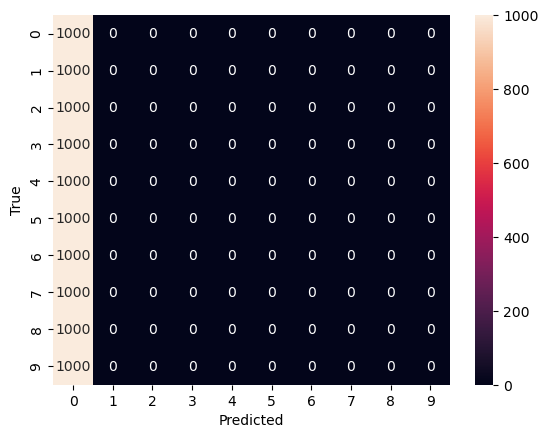

In [7]:
import numpy as np

all_labels = []
all_predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

# Concatenate all batches
all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

# Calculate metrics
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

# Print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
